# Sujet PLDAC : Interpolation contextualisée


**Enseignants**: Vincent Guigue & Nicolas Baskiotis


## **Contexte :**
L’idée est de développer des algorithmes prédictifs et d’interpolation sur les trajectoires
GPS de voiture.<br/>
En effet, la plupart des traces disponibles sont en très bas échantillonnage... Ce qui bride de nombreuses application.<br/>
A partir d’un ensemble de données *T* = {x<sub>1</sub>, ... , x<sub>t</sub>, ..  , x<sub>T</sub>} ∈ *R<sup>2×T</sup>*, il est possible de
chercher à prédire *x<sub>T+1</sub>* : cela constitue un problème classique.<br/> Il est aussi possible de chercher
à prédire *x<sub>t+1/2</sub>* qui se situe entre les pas de temps *t* et *t+1*.<br/>
Nous nous intéressons à ces problèmes... Mais en ajoutant un ingrédient important :
la connaissance du contexte. En effet, à certaines intersections, on peut trouver à partir
des observations du passé que tout le monde tourne à gauche : sachant cela, les problèmes
précédents deviennent plus faciles.<br/>
A partir d’une base des traces GPS haute fréquence sur la ville de Détroit, le but est
d’apprendre à la fois les modèles de prédiction/interpolation et une représentation du contexte
spatial.

------------

## Description rapide

**Fichier:  DataGpsDas.csv**<br>
Source : https://catalog.data.gov/dataset/safety-pilot-model-deployment-data <br/>

-----------------------

**Nombre de lignes total dans le fichier :** 41,021,227 <br/>
**Nombre de colonnes :** 17

------------------------

**Nom des colonnes :**   ['Device', 'Trip', 'Time', 'GpsTime', 'GpsWeek', 'GpsHeading',
       'GpsSpeed', 'Latitude', 'Longitude', 'Altitude', 'NumberOfSats',
       'Differential', 'FixMode', 'Pdop', 'GpsBytes', 'UtcTime', 'UtcWeek']

-----------------------

### **Description de quelques colonnes :**<br/><br/>



**Attribute Label:  DeviceID (column 0)** <br/>
**Attribute Definition:** This field contains the unique, numeric ID assigned to each DAS. This ID also doubles as a vehicle’s ID. <br/>
**Attribute Domain Values:** Integer

------------------

**Attribute Label: Trip (column 1)** <br/>
**Attribute Definition:** This field contains a count of ignition cycles—each ignition cycle commences when the ignition is in the on position and ends when it is in the off position. <br/>
**Attribute Domain Values:** Integer

------------------

**Attribute Label: Time (column 2)** <br/>
**Attribute Definition:** This field contains the time in centiseconds since DAS started, which (generally) starts when the ignition is in the on position. <br/>
**Attribute Domain Values:** Integer

-------------------

**Attribute Label: GPS_Speed  (column 6)** <br/>
**Attribute Definition:** This field contains the speed, in meters/second, of vehicle according to GPS. <br/>
**Attribute Domain Values:** Float

-------------------

**Attribute Label: GPS_Latitude (column 7)** <br/> 
**Attribute Definition:** This field contains the latitude, in degrees, of vehicle according to GPS.<br/> 
**Attribute Domain Values:** Float


-------------------


**Attribute Label: GPS_Longitude (column 8)**<br/>
**Attribute Definition:** This field contains the longitude, in degrees, of vehicle according to GPS.<br/>
**Attribute Domain Values:** Float

-------------------

**Attribute Label: GPS_Pdop  (column 13)** <br/>
**Attribute Definition:** This field contains the Positional Dilution of Precision, used to determine position accuracy; the lower the number, the better. <br/>
**Attribute Domain Values:** Float

### Importation de librairies

In [1]:
#Importation de librairies
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importation de fichiers contenant des fonctions
import dataSource as ds
import dataVisualization as dv

### Lecture du fichier

In [2]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

Informations tirées du pdf *Motion ResNet : An efficient data imputation method for spatio-temporal series* :

1. "We took trajectories only passing in a defined perimeter centered in latitude 42.282970 and longitude -83.735390, all positions within **latitude 42.282970±0.003000** and **longitude −83.735390±0.003000** are kept."


2. "Also we keep only trajectories with **at least 100 data points** so that we have enough dynamics to learn something."

In [3]:
#1.
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#2.
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Affichage du dataframe
df

,Device,Trip,Time,GpsTime,GpsWeek,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,NumberOfSats,Differential,FixMode,Pdop,GpsBytes,UtcTime,UtcWeek
120957,10204,268,72571,506824400,1708,239.485600,7.54,42.285965,-83.733940,212.93100,12,1,4,1.32,4,506808400,1708
120958,10204,268,72591,506824600,1708,239.828290,7.49,42.285957,-83.733955,212.98801,13,1,4,1.30,4,506808600,1708
120959,10204,268,72612,506824800,1708,239.733800,7.42,42.285954,-83.733971,213.04300,13,1,4,1.30,4,506808800,1708
120960,10204,268,72633,506825000,1708,239.743190,7.42,42.285946,-83.733986,213.08299,13,1,4,1.30,10,506809000,1708
120961,10204,268,72652,506825200,1708,239.775100,7.38,42.285938,-83.734001,213.12100,13,1,4,1.30,4,506809200,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,17101,28,1595811,492287200,1710,60.193279,11.00,42.285923,-83.733826,212.14600,11,1,4,1.58,4,492271200,1710
997736,17101,28,1595830,492287400,1710,60.422611,10.99,42.285934,-83.733803,212.07300,11,1,4,1.58,4,492271400,1710
997737,17101,28,1595851,492287600,1710,60.365929,10.98,42.285942,-83.733780,211.98599,11,1,4,1.58,4,492271600,1710
997738,17101,28,1595870,492287800,1710,60.441559,10.90,42.285954,-83.733749,211.89700,11,1,4,1.58,4,492271800,1710


### Detail sur l'intervalle de temps entre chaque récupération de données

In [4]:
#time est une liste qui contiendra le temps passé entre deux récupérations de données pour tous les trips
time = np.array([])

#Parcourt sur les trips car le temps de départ pour les trips est différent
for t in trips:
    #Récupération des données de temps du GPS pour le trip t
    tr = df.loc[df["Trip"]==t, "GpsTime"]
    #Rajout des différences de temps entre les lignes de données dans la liste time
    time = np.concatenate((time,[np.abs(tr.iloc[i+1] - tr.iloc[i]) for i in range(tr.shape[0]-1)]))

#Récupération des valeurs uniques et de leur effectif
values_time, counts = np.unique(time, return_counts=True)
print(f"Les différentes valeurs du temps passé entre deux points :\n{values_time}\n")
print(f"Et leur effectif :\n{counts}")

Les différentes valeurs du temps passé entre deux points :
[2.0000e+02 4.0000e+02 1.4440e+05 1.8420e+05 2.6520e+05 3.0780e+05
 3.3480e+05 3.4440e+05 3.6060e+05 3.7080e+05 3.8060e+05 3.8500e+05
 4.0880e+05 4.1940e+05 4.5240e+05 4.7700e+05 5.0560e+05 5.2880e+05
 8.1120e+05 9.0800e+05 9.2480e+05 9.3760e+05 9.6240e+05 9.7440e+05
 1.0250e+06 1.0352e+06 1.0448e+06 1.0502e+06 1.0788e+06 1.0814e+06
 1.1016e+06 1.1536e+06 1.3462e+06 2.0598e+06 2.1082e+06 2.7984e+06]

Et leur effectif :
[34939   386     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1]


On choisit d'ignorer les outliers (ceux qui apparaissent une seule fois) :

(array([34939.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   386.]),
 array([200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.]),
 <BarContainer object of 10 artists>)

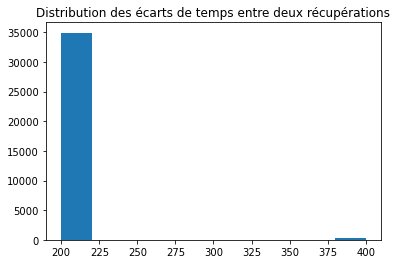

In [5]:
values_time = values_time[counts>1]
counts = counts[counts>1]
plt.title("Distribution des écarts de temps entre deux récupérations")
plt.hist(values_time, weights=counts)

Peut-on en déduire que l'échantillonnage des points est fixe (avec un écart de 200 millisecondes) ?

### Exploration des données

**Quelques statistiques de base sur certaines colonnes ...**

In [6]:
colonnes = ['Time','GpsTime','GpsHeading', 'GpsSpeed','Latitude', 'Longitude', 'Altitude','Pdop']

df[colonnes].describe()

,Time,GpsTime,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,Pdop
count,3.537200e+04,3.537200e+04,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000
mean,4.781673e+05,4.423678e+08,211.952805,5.031042,42.282868,-83.735335,229.294582,1.914650
std,4.307300e+05,6.020981e+07,93.302970,4.527492,0.001508,0.001193,10.643619,2.568222
min,8.866000e+03,2.221358e+08,0.000200,0.000000,42.279972,-83.738380,207.424000,1.230000
25%,1.670110e+05,4.325398e+08,175.623400,0.150000,42.281387,-83.735771,223.694757,1.530000
50%,3.488350e+05,4.452121e+08,209.716710,4.610000,42.283173,-83.735550,230.304000,1.690000
75%,6.752512e+05,4.844326e+08,268.795043,8.440000,42.283470,-83.734573,236.293000,1.980000
max,1.595894e+06,5.876186e+08,359.996490,17.170000,42.285969,-83.732391,304.120000,99.989998


**Visualisation des colonnes Longitude et Latitude :**

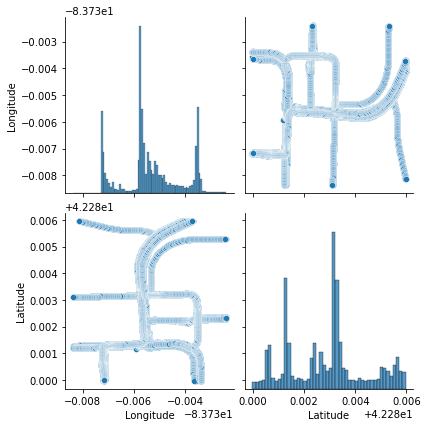

In [7]:
sns.pairplot(df[["Longitude", "Latitude"]], height=3)

**Distribution de la vitesse des GPS :**

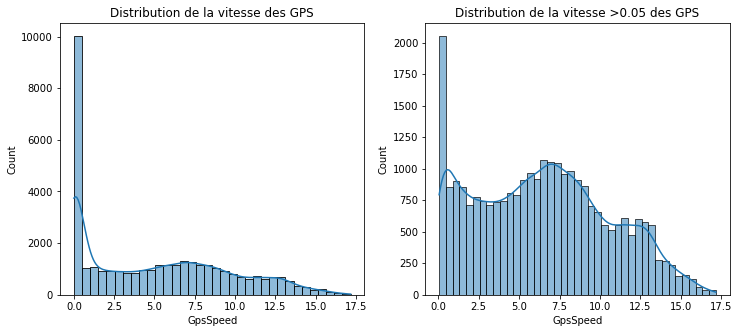

In [8]:
fig, ax =plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution de la vitesse des GPS')
sns.histplot(df["GpsSpeed"], kde=True, ax=ax[0])
ax[1].set_title('Distribution de la vitesse >0.05 des GPS')
sns.histplot(df.loc[df["GpsSpeed"]>0.05, "GpsSpeed"], kde=True, ax=ax[1])
plt.show()

**Calcul des paramètres**

In [9]:
#bins / nombre d'intervalles
n_interval = 10

#récupération de paramètres
latitude_min, latitude_max, longitude_min, longitude_max, ecart_x, ecart_y = ds.calcul_param(df)

#On sépare en n_interval la latitude et la longitude
x_splits = np.linspace(latitude_min,latitude_max, n_interval)
y_splits = np.linspace(longitude_min,longitude_max, n_interval)

**Calcul de l'effectif et de la vitesse moyenne de chaque case:**

In [10]:
e, v = ds.calcul_eff_vit_moy(df,  latitude_min, longitude_min, ecart_x, ecart_y, n_interval)

df["Effectif_case"] = e    
df["Vitesse_moy_case"] = v

**Visualisation graphique de la carte :**

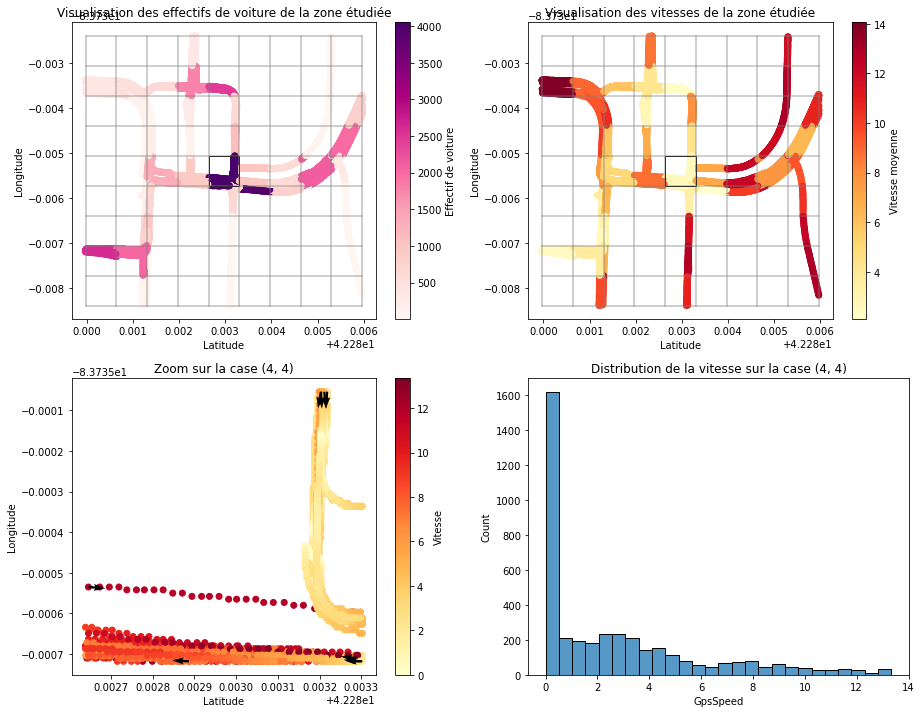

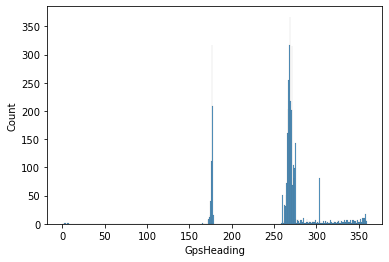

In [11]:
#case sur laquelle on veut visualiser
pos = (4,4)

#Visualisation graphique de la carte
dv.affiche_carte(df, pos, latitude_min, latitude_max, longitude_min, longitude_max, ecart_x, ecart_y, n_interval)

#Histogramme des valeurs de GpsHeading
case_df = ds.trouve_data_case(df, pos, latitude_min, longitude_min, ecart_x, ecart_y)
dv.afficher_histogramme_df(case_df,"GpsHeading")

**Histogramme 3D de la norme des vecteurs de vitesse et ses angles $\Theta$ :**

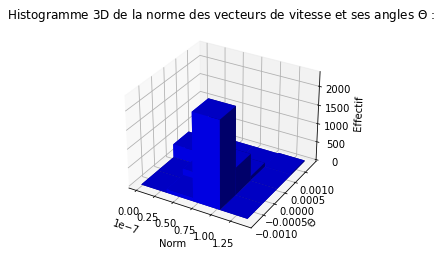

In [12]:
dv.afficher_hist_norm_vit(df, pos, latitude_min, longitude_min, ecart_x, ecart_y)

# Modele Physique

### Importation des fichiers

In [13]:
#Importation des fichiers
import model_physique as m_phys
import methods as mtds

mp = m_phys.modele_physique()

### Explication du modele

### Implementation

### Test

### Base sur les points precedentes

In [14]:
datax = []
tr_arr = tr.to_numpy()
for i in range(len(tr)-2):
    datax.append([tr_arr[i],tr_arr[i+1],tr_arr[i+2]])
    i+=3

datax = np.array(datax)

datax

array([[268159200, 268159400, 268159600],
       [268159400, 268159600, 268159800],
       [268159600, 268159800, 268160000],
       [268159800, 268160000, 268160200],
       [268160000, 268160200, 268160400],
       [268160200, 268160400, 268160600],
       [268160400, 268160600, 268160800],
       [268160600, 268160800, 268161000],
       [268160800, 268161000, 268161200],
       [268161000, 268161200, 268161400],
       [268161200, 268161400, 268161600],
       [268161400, 268161600, 268161800],
       [268161600, 268161800, 268162000],
       [268161800, 268162000, 268162200],
       [268162000, 268162200, 268162400],
       [268162200, 268162400, 268162600],
       [268162400, 268162600, 268162800],
       [268162600, 268162800, 268163000],
       [268162800, 268163000, 268163200],
       [268163000, 268163200, 268163400],
       [268163200, 268163400, 268163600],
       [268163400, 268163600, 268163800],
       [268163600, 268163800, 268164000],
       [268163800, 268164000, 2681

In [15]:
#def moindre_c(X_predit, X_test):
#    return ((X_predit-X_test)**2).sum()

#mp.score(moindre_c, datax)

### Base sur l'attribut GpsHeading et GpsSpeed

## Regression Linéaire avec sklearn

#### Importation de librairies/fichiers

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#fichier contenant des classes pour transformer et evaluer les données
import Eval

In [17]:
from sklearn.base import BaseEstimator, RegressorMixin

class physic_model(BaseEstimator,RegressorMixin):
    def __init__(self, freq):
        super().__init__()
        self.v = {}
        self.freq = freq

    def fit(self, X, y):
        '''
        caculate parameters vector speed self.v for one trajectory by taking the last 2 data points
        Parameters
        ----------
        X : previous data points [[Trip,Lat,Lon,GpsTime]*m]
        y : current data points  [[Trip,Lat,Lon,GpsTime]*m]
        '''
        mat = []
        groups = X.groupby('Trip')
        for t in groups:
            trip_i = t[1][['Latitude', 'Longitude', 'GpsTime']].to_numpy()
            # take continuous points, step = freq//200
            tmp = []
            for i in range(0,len(trip_i),int(self.freq//200)):
                tmp.append(trip_i[i])

            mat.append(tmp)

        a,b = y.to_numpy()[:,-1],X.to_numpy()[:,-1]
        v_speed = (b[:2] - a[:2])/(a[-1] - b[-1])
        self.v = v_speed
        return self

    def predict(self,X):
        '''
        predict next position
        Parameters
        ----------
        X : [[Trip,Lat,Lon,Duration]*M]
        Duration is the diff between GpsTime of y_test and that of x_test
        '''
        M,N = X.shape
        res = np.zeros((M,2))
        for i in range(M):
            res[i] = self.v*X.to_numpy()[i,2] + X.to_numpy()[i,:2]
        return res


#### Paramètres pour la contruction des jeux de données

In [18]:
#on prend un point sur 'step' du jeu de données
freq = 200

#features
attrs_x = [['Latitude','Longitude','GpsSpeed','GpsHeading','Trip'],['Trip','Latitude','Longitude','GpsTime']]

#targets
labels = ['Latitude','Longitude']

#models
models = [LinearRegression(), physic_model(freq)]

#preprocessing
#preprocessor = [MinMaxScaler() for _ in range(len(models))]
preprocessor = None

#### Création des données d'apprentissage et de test et évaluation des modèles

In [19]:
#création des données d'apprentissage et de test pour la prédiction du prochain point (à partir de toutes nos données)
traitement = Eval.Traitement(df, attrs_x, labels, preprocessor)
traitement.set_data_train_test(ds.create_data_xy, freq, test_size=0.2, random_state=0)

#Apprentissage des modèles et évaluation à partir de l'objet traitement
evaluateur = Eval.Evaluation(models,traitement)
evaluateur.fit()

#Affichage des résultats
evaluateur.afficher_resultats()

Score obtenu pour le modèle 0          : 0.9974072380096306
Score obtenu pour le modèle 1          : -23673987000.92953

MSE obtenue pour le modèle  0          : 3.7497020982807024e-09
MSE obtenue pour le modèle  1          : 36147.65270975425



Matrice l'erreur MSE pour chaque label :


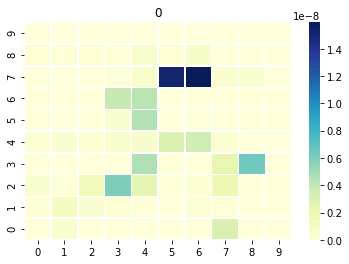

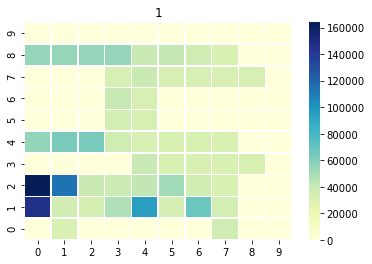

In [20]:
from sklearn.metrics import mean_squared_error

# liste matrices erreurs des cases
l_mat_err= [np.zeros((n_interval, n_interval)) for i in range(len(models))]
# parcours de toutes les cases
for i in range(n_interval):
    for j in range(n_interval):
        # récupération des données de la case
        case_df=ds.trouve_data_case(df, (i, j), latitude_min, longitude_min, ecart_x, ecart_y)
        if case_df.shape[0] > 0:
            traitement = Eval.Traitement(case_df, attrs_x, labels, preprocessor)
            traitement.set_data_train_test(ds.create_data_xy, freq, test_size=0.2, random_state=0)
            
            l_ypred = evaluateur.predict(traitement.l_Xtest)

            for mi in range(len(models)):               
                l_mat_err[mi][n_interval-1-i, j] = mean_squared_error(traitement.l_Ytest[mi],l_ypred[mi])

print("Matrice l'erreur MSE pour chaque label :")
for m in range(len(l_mat_err)):
    plt.figure()
    plt.title(m)
    sns.heatmap(l_mat_err[m], linewidths=.5, cmap="YlGnBu", yticklabels=np.arange(n_interval-1, -1, -1))

0


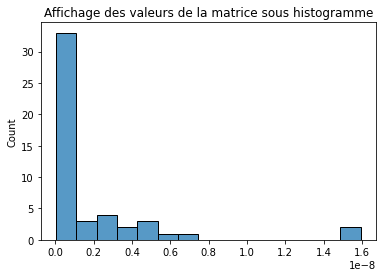

1


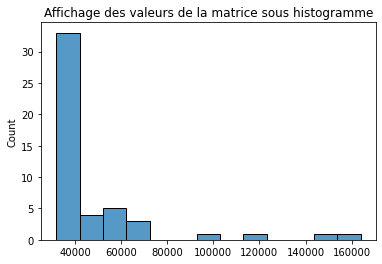

In [21]:
for mi in range(len(l_mat_err)):
    print(mi)
    dv.afficher_mat_hist(l_mat_err[mi])